In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table
import fitsio
import descwl
import os
from sklearn.neighbors import KDTree

In [3]:
btf_dir = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf'

In [4]:
truth_table = fitsio.read(os.path.join(btf_dir,'LSST_i_lite.fits'),ext=1)

In [5]:
truth_image = fitsio.read(os.path.join(btf_dir,'LSST_i_lite.fits'),ext=0)

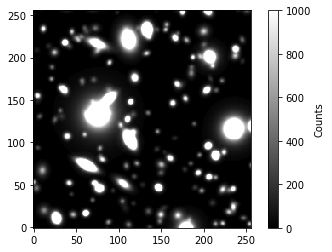

In [6]:
#Let's check the noiseless image (I only show a fraction of it because the 4096 x 4096 image is heavy to render)
plt.imshow(truth_image[0:256,0:256],cmap='gray',vmax=1000,origin='lower')
plt.colorbar(label='Counts')

In [7]:
truth_table.dtype.fields

mappingproxy({'a': (dtype('>f4'), 86),
              'ab_mag': (dtype('>f4'), 58),
              'b': (dtype('>f4'), 90),
              'beta': (dtype('>f4'), 94),
              'db_id': (dtype('>i8'), 0),
              'dg1': (dtype('>f4'), 130),
              'dg1_grp': (dtype('>f4'), 142),
              'dg2': (dtype('>f4'), 134),
              'dg2_grp': (dtype('>f4'), 146),
              'ds': (dtype('>f4'), 126),
              'ds_grp': (dtype('>f4'), 138),
              'dx': (dtype('>f4'), 46),
              'dy': (dtype('>f4'), 50),
              'e1': (dtype('>f4'), 78),
              'e2': (dtype('>f4'), 82),
              'f_bulge': (dtype('>f4'), 42),
              'f_disk': (dtype('>f4'), 38),
              'flux': (dtype('>f4'), 66),
              'g1_fit': (dtype('>f4'), 162),
              'g2_fit': (dtype('>f4'), 166),
              'grp_id': (dtype('>i8'), 8),
              'grp_rank': (dtype('>i2'), 18),
              'grp_size': (dtype('>i2'), 16),
              'h

In [8]:
# For some reason fitsio doesn't recognize this properly...
#dm_table = fitsio.read(os.path.join(btf_dir,'LSST_i_DM.fits.gz'),ext=1)
dm_table = astropy.table.Table.read(os.path.join(btf_dir,'LSST_i_DM.fits.gz'))

In [9]:
dm_table

flags [72],id,coord_ra,coord_dec,parent,deblend_nChild,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_flux_xy_Cov,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_Variance_value,footprint
,,rad,rad,,,pix,pix,,pix,pix,pix,pix,pix,pix,pix,pix,,,ct,ct,,ct,ct,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,
bool,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
False .. False,1,6.28128420571,-0.0019356737615,0,0,nan,nan,nan,27.0768598578,11.4383378685,27.0176311249,11.0608926431,27.0,11.0,nan,nan,0.0,0.0,543616.360358,543616.360358,nan,nan,nan,5.24338381124,7.0228386036,-0.591476181352,5.24338381124,7.0228386036,-0.591476181352,nan,nan,nan,nan,nan,nan,5.25971206206,7.0545377877,-0.589759438143,0.0296036,0.0243561,0.0397055,27.0410528232,11.2206074577,550639.486067,1549.59905583,2.92273950734,2.92273950734,-1.17672300434e-08,-22.9368,2.57185,-30.7638,286850.75,527.665100098,436901.4375,655.729370117,522410.90625,721.01171875,581724.5,762.749755859,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,550639.486067,1095.73201426,402845.133849,736.355675167,9.10712432861,1
False .. False,2,6.28143208746,-0.00194124647768,0,2,nan,nan,nan,180.0,6.0,179.845709721,5.90871460977,180.0,6.0,nan,nan,0.0,0.0,250021.211212,250021.211212,nan,nan,nan,8.22149905158,33.1894654805,1.86002904957,8.22149905158,33.1894654805,1.86002904957,nan,nan,nan,nan,nan,nan,6.87758899633,1

In [10]:
dm_table = dm_table[dm_table['deblend_nChild']==0] # Only fully deblended objects

In [11]:
wld_cat = descwl.output.Reader(os.path.join(btf_dir,'LSST_i_lite.fits')).results

We employ a nearest neighbors approach using the centroids to match input and output

In [12]:
def match(catalog,truth,wld_cat):
    width,height = wld_cat.survey.image_width,wld_cat.survey.image_height
    X = np.zeros((len(catalog),2))  
    X[:,0] = catalog['base_SdssCentroid_x']
    X[:,1] = catalog['base_SdssCentroid_y']
    X2 = np.zeros((truth.shape[0],2))
    X2[:,0]=truth['dx']/wld_cat.survey.pixel_scale+0.5*width
    X2[:,1]=truth['dy']/wld_cat.survey.pixel_scale+0.5*height
    tree = KDTree(X2,metric='euclidean')
    #Let's try to match to nearest neighbor for now
    dist, ind = tree.query(X,k=1)
    return dist.flatten(),ind.flatten()

In [13]:
dist, ind = match(dm_table,truth_table,wld_cat)

In [14]:
print('Fraction of multiple matches: ',1.0-len(np.unique(ind))/(1.0*len(ind)))

Fraction of multiple matches:  0.000876863334586031


In [15]:
unique_ind, ind_counts = np.unique(ind,return_counts=True)

# N(z)

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


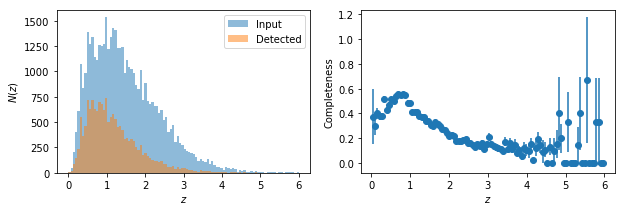

In [16]:
h_in, bin_edges = np.histogram(truth_table['z'],range=(0,6),bins=100)
h_out, bin_edges = np.histogram(truth_table['z'][ind],range=(0,6),bins=100)
f, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(truth_table['z'],range=(0,6),bins=100,label='Input',alpha=0.5)
ax[0].hist(truth_table['z'][ind],range=(0,6),bins=100,label='Detected',alpha=0.5)
ax[1].errorbar(0.5*bin_edges[1:]+0.5*bin_edges[:-1],h_out*1.0/h_in,np.sqrt(h_out)/h_in+h_out*1.0/(h_in)**3./2,fmt='o')
for i in range(0,2):
    ax[i].set_xlabel('$z$')
    ax[i].legend(loc='best')
ax[0].set_ylabel('$N(z)$')
ax[1].set_ylabel('Completeness');

# N(m)

/global/common/software/lsst/common/miniconda/py3-4.2.12/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


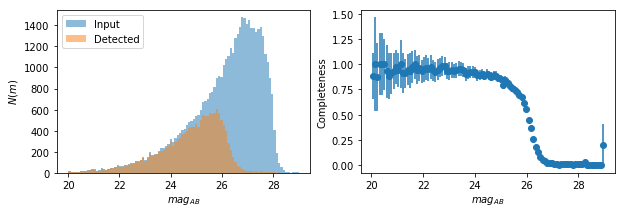

In [17]:
h_in, bin_edges = np.histogram(truth_table['ab_mag'],range=(20,29),bins=100)
h_out, bin_edges = np.histogram(truth_table['ab_mag'][ind],range=(20,29),bins=100)
f, ax = plt.subplots(1,2,figsize=(10,3))
ax[0].hist(truth_table['ab_mag'],range=(20,29),bins=100,label='Input',alpha=0.5)
ax[0].hist(truth_table['ab_mag'][ind],range=(20,29),bins=100,label='Detected',alpha=0.5)
ax[1].errorbar(0.5*bin_edges[1:]+0.5*bin_edges[:-1],h_out*1.0/h_in,np.sqrt(h_out)/h_in+h_out*1.0/(h_in)**3./2,fmt='o')
for i in range(0,2):
    ax[i].set_xlabel('$mag_{AB}$')
    ax[i].legend(loc='best')
ax[0].set_ylabel('$N(m)$')
ax[1].set_ylabel('Completeness');

# Check one of the groups

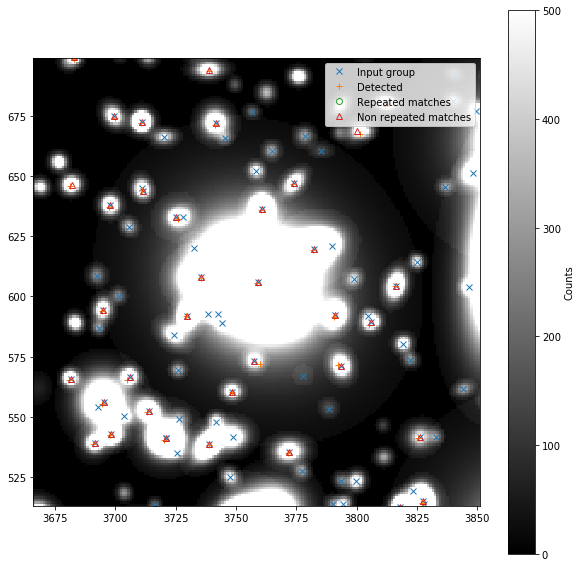

In [18]:
plt.figure(figsize=(10,10))
big_group = np.unique(truth_table['grp_id'][np.argmax(truth_table['grp_size'])]) #Select the ID of the largest group
padding=25
xmin = int(truth_table['xmin'][truth_table['db_id']==big_group])-padding
xmax = int(truth_table['xmax'][truth_table['db_id']==big_group])+padding
ymin = int(truth_table['ymin'][truth_table['db_id']==big_group])-padding
ymax = int(truth_table['ymax'][truth_table['db_id']==big_group])+padding
# Show only the members of the group
xt = truth_table['dx'][truth_table['grp_id']==big_group]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
yt = truth_table['dy'][truth_table['grp_id']==big_group]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
plt.imshow(truth_image[ymin:ymax,xmin:xmax],origin='lower',cmap='gray',vmax=500,extent=[xmin,xmax,ymin,ymax])
plt.plot(xt,yt,'x',label='Input group')
mask = dm_table['deblend_nChild']==0
plt.plot(dm_table['base_SdssCentroid_x'][mask],dm_table['base_SdssCentroid_y'][mask],'+',label='Detected')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
# Show repeated matches
xtt = truth_table['dx'][unique_ind[ind_counts>1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
ytt = truth_table['dy'][unique_ind[ind_counts>1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
xttt = truth_table['dx'][unique_ind[ind_counts==1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_width
yttt = truth_table['dy'][unique_ind[ind_counts==1]]/wld_cat.survey.pixel_scale+0.5*wld_cat.survey.image_height
plt.plot(xtt,ytt,'o',fillstyle='none',label='Repeated matches')
plt.plot(xttt,yttt,'^',fillstyle='none',label='Non repeated matches')
plt.legend(loc='best')
plt.colorbar(label='Counts');

We can see that the deblender has some problems with certain sources.

# Blendedness

In [ ]:
plt.scatter(truth_table['purity'][ind],dm_table['base_Blendedness_raw_flux'][dm_table['deblend_nChild']==0],s=0.1)
plt.xlabel('Purity')
plt.ylabel('Blendedness');